In [1]:
# Author(s): RMichael, MPrine
# Data Source: https://www.ftc.gov/site-information/open-government/data-sets/do-not-call-data

# The data set includes information on Do Not Call and robocall complaints reported to the 
# Federal Trade Commission. The data set contains information reported by consumers, including 
# the telephone number originating the unwanted call, the date the complaint was created, the 
# time the call was made, the consumer’s city and state locations reported, the subject of the 
# call, and whether the call was a robocall. None of the information about the reported calls is verified.

# If you would like to add, modify, or remove data, please do so in the "Do Not Call Data" Directory

In [71]:
import os, json, csv, sqlite3, math
from collections import namedtuple

import pandas as pd
from pandas import DataFrame, Series

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

import numpy as np

from pylab import *

import requests
matplotlib.rcParams["font.size"] = 12

import datetime, calendar
from datetime import datetime

import plotly.graph_objects as go
import plotly.express as px

In [3]:
def find_day(date):
    year, month, day = (int(x) for x in date.split('-'))
    day = datetime(year, month, day).weekday()
    return calendar.day_name[day]
find_day('2021-04-15')

'Thursday'

In [4]:
def process_csv(folder, file_name):
    csv_file = open(os.path.join(folder,file_name), encoding="utf-8")
    csv_reader = csv.reader(csv_file)
    csv_rows = list(csv_reader)
    csv_file.close()
    return csv_rows

def get_csv_header(folder, file_name):
    csv_file = open(os.path.join(folder,file_name), encoding="utf-8")
    csv_reader = csv.reader(csv_file)
    csv_data = list(csv_reader)
    csv_header = csv_data[0]
    return csv_header

def get_csv_data(folder, file_name):
    csv_file = open(os.path.join(folder,file_name), encoding="utf-8")
    csv_reader = csv.reader(csv_file)
    csv_sheet = list(csv_reader)
    csv_data = csv_sheet[1:]
    return csv_data

def format_suffix(cell):
    if cell.lower().endswith('k'):
        new_cell = cell.lower().replace('k', '').split()[0]
        return int(float(new_cell) * 10**3)
    elif cell.lower().endswith('m'):
        new_cell = cell.lower().replace('m', '').split()[0]
        return int(float(new_cell) * 10**6)
    elif cell.lower().endswith('b'):
        new_cell = cell.lower().replace('b', '').split()[0]
        return int(float(new_cell) * 10**9)
    elif cell == '' or cell == 'unknown' or cell == 'unkown':
            return 0
    else:
        return int(cell)
    
def list_files(directory):
    return os.listdir(directory)

def list_complaints_dictionaries(folder, file_name):
    csv_rows = process_csv(folder, file_name)
    csv_header = get_csv_header(folder, file_name)
    csv_data = get_csv_data(folder, file_name)
    complaint_list = []
    for row in csv_data:
        column_count = 0
        complaint_dictionary = {}
        for item in row:
            complaint_dictionary[csv_header[column_count]] = item
            column_count += 1
        complaint_list.append(complaint_dictionary)
    return complaint_list
#list_complaints('Do Not Call Data', 'dnc_complaint_numbers_2021-04-01.csv')

In [5]:
#Q1: What files, their paths, and how many files are present in the "Do Not Call Data" directory?

def list_paths(directory):
    files = list_files(directory)
    file_paths = []
    for file in files:
        file_paths.append(os.path.join(directory, file))
    return file_paths
list_paths('Do Not Call Data'), len(list_files('Do Not Call Data'))

(['Do Not Call Data\\dnc_complaint_numbers_2021-04-01.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-02.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-05.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-06.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-07.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-08.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-12.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-13.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-14.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-15.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-16.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-19.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-20.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-21.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-22.csv',
  'Do Not Call Data\\dnc_complaint_numbers_2021-04-23.csv',
  'Do Not Call Data\\dnc_complaint_numbe

In [6]:
#Q2: Create a List of all rows from all files in the Do Not Call Data folder.

def accumulate_data_rows(directory):
    cumulative_complaints = []
    for filename in os.listdir(directory):
        cumulative_complaints.extend(get_csv_data(directory, filename))
    return cumulative_complaints
dnc_april_data = accumulate_data_rows('Do Not Call Data')
dnc_april_data

[['17607713241',
  '3/31/2021 0:00',
  '3/31/2021 0:00',
  '',
  'California',
  '510',
  'No Subject Provided',
  'Y'],
 ['9562330462',
  '3/31/2021 0:00',
  '3/29/2021 11:41',
  '',
  'Wisconsin',
  '920',
  'Other',
  'Y'],
 ['3148669631',
  '3/31/2021 0:00',
  '3/30/2021 12:09',
  'University City',
  'Missouri',
  '314',
  'Other',
  'N'],
 ['2534465015',
  '3/31/2021 0:00',
  '3/30/2021 11:14',
  'San Pedro',
  'California',
  '310',
  'Reducing your debt (credit cards, mortgage, student loans)',
  'N'],
 ['6232671568',
  '3/31/2021 0:01',
  '3/30/2021 18:10',
  '',
  'Arizona',
  '520',
  'Other',
  'Y'],
 ['6236940887',
  '3/31/2021 0:01',
  '3/30/2021 17:06',
  'Mesa',
  'Arizona',
  '608',
  'Other',
  ''],
 ['2817677726',
  '3/31/2021 0:01',
  '3/30/2021 14:12',
  'Houston',
  'Texas',
  '281',
  'Other',
  'N'],
 ['6172774135',
  '3/31/2021 0:02',
  '3/29/2021 10:49',
  '',
  'Massachusetts',
  '617',
  'Dropped call or no message',
  ''],
 ['2178323338',
  '3/31/2021 0:02'

In [7]:
#Q3: What states do the Do Not Call complaints originate?

def consumer_states():
    consumer_states = []
    for row in dnc_april_data:
        row = row[4].strip()
        if row == '':
            continue
        elif row not in consumer_states:
            consumer_states.append(row)
    consumer_states.sort()
    return consumer_states
consumer_states()

['APO EUROPE',
 'Alabama',
 'Alaska',
 'American Samoa',
 'Arizona',
 'Arkansas',
 'British Columbia, Canada',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Guam',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Brunswick, Canada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Northern Mariana Islands',
 'Nova Scotia, Canada',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Puerto Rico',
 'Quebec, Canada',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'US Military Latin America',
 'US Military Pacific',
 'Utah',
 'Vermont',
 'Virgin Islands',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

In [8]:
#Q4: What are the subjects of the complaints?

def subject_types():
    subject_types = []
    for row in dnc_april_data:
        row = row[6].strip()
        if row not in subject_types:
            subject_types.append(row)
    return subject_types
subject_types()

['No Subject Provided',
 'Other',
 'Reducing your debt (credit cards, mortgage, student loans)',
 'Dropped call or no message',
 'Calls pretending to be government, businesses, or family and friends',
 'Warranties  & protection plans',
 'Lotteries, prizes  & sweepstakes',
 'Vacation  & timeshares',
 'Energy, solar,  & utilities',
 'Home security  & alarms',
 'Medical  & prescriptions',
 'Computer  & technical support',
 'Charities',
 'Home improvement  & cleaning',
 'Work from home  & other ways to make money',
 'Debt collection']

In [9]:
#Q5: What percent of the complaint subjects are 'Dropped call or no message'?

def percentage_subject_by_type(type):
    search_type_total = float(0)
    subject_total = float(0)
    for row in dnc_april_data:
        subject_total += 1
        if row[6] == type:
            search_type_total += 1
    percent = round((search_type_total/subject_total), 3)
    return "{:.2%}".format(percent)
percentage_subject_by_type('Dropped call or no message')

'12.90%'

In [10]:
#Q6: What percent of the complaint subjects are do not have a subject?

percentage_subject_by_type('No Subject Provided')

'15.70%'

In [11]:
#Q7: What percent of the complaint subjects are 'Calls pretending to be government, businesses, or family and friends'?

percentage_subject_by_type('Calls pretending to be government, businesses, or family and friends')

'15.30%'

In [12]:
#Q8: What percent of the calls were robocalls 'Y or N'?

def percentage_robocalls(type):
    search_type_total = float(0)
    robocall_total = float(0)
    for row in dnc_april_data:
        robocall_total += 1
        if row[7] == type:
            search_type_total += 1
    percent = round((search_type_total/robocall_total), 3)
    return "{:.2%}".format(percent)
percentage_robocalls('Y')

'70.20%'

In [13]:
#Q9: What numbers have the most recorded complaints with at least 100 calls?

def most_number_calling(amount):
    company_phone_number_list = {}
    final_list = {}
    for row in dnc_april_data:
        if row[0] not in company_phone_number_list:
            company_phone_number_list[row[0]] = 1
        else:
            company_phone_number_list[row[0]] += 1
    for key in company_phone_number_list:
        if key == '':
            continue
        elif company_phone_number_list.get(key) > amount:
            final_list[key] = company_phone_number_list.get(key)
        else:
            continue
    final_list = dict(sorted(final_list.items(), key=lambda item: item[1], reverse=True))
    return final_list
most_number_calling(100)

{'3152328257': 609,
 '8333041447': 506,
 '8664913534': 243,
 '8008924357': 225,
 '9892568058': 183,
 '8889820154': 148,
 '8664882192': 141,
 '5012740454': 124,
 '4073513878': 122,
 '4806906563': 121,
 '8883204689': 119,
 '2484584585': 115}

In [14]:
#Q10 What numbers have the most recorded complaints with at least 500 calls?

most_number_calling(500)

{'3152328257': 609, '8333041447': 506}

In [15]:
#Q11 Find day of the week for corresponding date.

find_day('2021-04-15')

'Thursday'

In [16]:
#In Progress, add two more questions afterwards.

#Q12: How many complaints were logged on '2021-04-16'?

def total_calls_by_state_by_date(date):
    total_calls = 0
    for row in dnc_april_data:
        row_date = row[2].split(" ", 1)
        #print(row_date)
        if date == row_date[0]:
            total_calls += 1
        else:
            continue
    return total_calls
total_calls_by_state_by_date("2021-04-16")

15338

In [17]:
#Q13: How many complaints did the number '5' log?

def number_times_company_called(number):
    company_count = 0
    for row in dnc_april_data:
        if row[0] == number:
            company_count += 1
    return company_count
number_times_company_called('5')

2

In [18]:
#Q14: How many complaints did the number '2052582457' log?

number_times_company_called('2052582457')

5

In [19]:
#Q15: How many complaints did the number '8007094274' log?

number_times_company_called('8007094274')

1

In [20]:
#Q16: What numbers were reported from area code 410?

def calling_number_by_customer_area_code(area_code):
    calling_number_list = []
    for row  in dnc_april_data:
        if row[5] == '':
            continue
        else:
            calling_number = int(row[5])
        if calling_number == area_code:
            if row[5] not in calling_number_list:
                if row[0]== '':
                    continue
                else:
                    calling_number_list.append(row[0])
    return calling_number_list
calling_number_by_customer_area_code(410)

['4102201870',
 '4107358726',
 '6198660606',
 '5209889103',
 '4107592379',
 '5734539027',
 '6092100036',
 '4109281776',
 '2705965641',
 '4106705753',
 '8776610854',
 '8034903661',
 '8453182344',
 '27786502565',
 '4253644251',
 '4107096181',
 '6085430483',
 '7858229939',
 '4433488567',
 '4432003459',
 '2679962265',
 '4105417496',
 '4108348794',
 '4432565518',
 '2403324887',
 '2137763104',
 '8708365475',
 '7185407383',
 '8453182188',
 '8884138803',
 '4102919294',
 '8336941396',
 '9805802782',
 '2626484333',
 '8667902990',
 '2132731585',
 '4103153163',
 '4432302053',
 '4459528234',
 '6672184427',
 '2317510610',
 '8059800372',
 '4107877684',
 '4109959241',
 '4108875912',
 '4102149018',
 '4102149018',
 '4102377245',
 '4107758614',
 '4439065006',
 '6195007937',
 '3015917072',
 '4108472538',
 '2104189371',
 '4104176740',
 '2762404166',
 '4102922887',
 '4809070617',
 '6465807961',
 '4103708051',
 '4105748879',
 '4104030196',
 '4104030196',
 '14102267884',
 '15864614324',
 '15864614324',
 '1586

In [21]:
#Q17: What numbers were reported from area code 937?

calling_number_by_customer_area_code(937)

['9375836580',
 '9375152518',
 '9376697265',
 '9377410827',
 '9372318275',
 '8495804416',
 '6786796015',
 '9372302618',
 '9374519746',
 '2087155628',
 '5134478287',
 '9372400125',
 '5039873060',
 '5672271364',
 '9374715635',
 '79376814119',
 '9378316116',
 '2249359187',
 '2249359187',
 '5133666813',
 '9376897000',
 '3308614075',
 '2292702829',
 '9376899258',
 '9375710470',
 '6305541935',
 '4082942862',
 '2055613772',
 '9370219904',
 '9377911031',
 '8557876725',
 '5135544793',
 '8608193164',
 '2202007322',
 '5131260295',
 '8557876725',
 '9377911000',
 '9373369152',
 '3802023334',
 '9377277344',
 '9377911061',
 '9373044244',
 '9372034886',
 '8006101771',
 '9377292082',
 '9377418227',
 '9133466166',
 '8665281217',
 '9374570953',
 '7134336110',
 '7134336110',
 '9378957299',
 '4146356913',
 '3177394018',
 '9379741979',
 '9373893565',
 '9373837522',
 '9374617500',
 '9378321327',
 '2127291407',
 '9374685930',
 '9379704214',
 '4235366589',
 '9374668420',
 '5627354705',
 '9375057679',
 '8453182

In [22]:
#Q18: Create a Pandas Dataframe from the CSV files.

def accumulate_data_dictionaries(directory):
    cumulative_complaints = []
    for filename in os.listdir(directory):
        cumulative_complaints.extend(list_complaints_dictionaries(directory, filename))
    return cumulative_complaints
dnc_april_data = accumulate_data_dictionaries('Do Not Call Data')
dnc_df = DataFrame(dnc_april_data)

# Separate Date and Time
dnc_df['date-time-obj'] = pd.to_datetime(dnc_df['Created_Date'], errors = 'coerce')
dnc_df['Created_Date'] = dnc_df['date-time-obj'].dt.date
dnc_df['Created_Time'] = dnc_df['date-time-obj'].dt.time
dnc_df['Created_Timestamp'] = dnc_df['date-time-obj']
del dnc_df['date-time-obj']

dnc_df['date-time-obj'] = pd.to_datetime(dnc_df['Violation_Date'], errors = 'coerce')
dnc_df['Violation_Date'] = dnc_df['date-time-obj'].dt.date
dnc_df['Violation_Time'] = dnc_df['date-time-obj'].dt.time
dnc_df['Violation_Timestamp'] = dnc_df['date-time-obj']
del dnc_df['date-time-obj']

# Create Day Columns
dnc_df['Created_Date'] = pd.to_datetime(dnc_df['Created_Date'], errors='coerce')
dnc_df['Violation_Date'] = pd.to_datetime(dnc_df['Violation_Date'], errors='coerce')

dnc_df['date-time-obj'] = pd.to_datetime(dnc_df['Created_Date'], errors = 'coerce')
dnc_df['Created_Day'] = dnc_df['date-time-obj'].dt.day_name()
del dnc_df['date-time-obj']

dnc_df['date-time-obj'] = pd.to_datetime(dnc_df['Violation_Date'], errors = 'coerce')
dnc_df['Violation_Day'] = dnc_df['date-time-obj'].dt.day_name()
del dnc_df['date-time-obj']

dnc_df = dnc_df[['Company_Phone_Number', 'Created_Timestamp', 'Created_Date', 'Created_Day', 'Created_Time', 'Violation_Timestamp', 'Violation_Date', 'Violation_Day', 'Violation_Time', 'Consumer_City', 'Consumer_State', 'Consumer_Area_Code', 'Subject', 'Recorded_Message_Or_Robocall']]
#cols = cols[-1:] + cols[:-1]
#cols = dnc_df.columns.tolist()
#cols
dnc_df

,Company_Phone_Number,Created_Timestamp,Created_Date,Created_Day,Created_Time,Violation_Timestamp,Violation_Date,Violation_Day,Violation_Time,Consumer_City,Consumer_State,Consumer_Area_Code,Subject,Recorded_Message_Or_Robocall
0,17607713241,2021-03-31 00:00:00,2021-03-31,Wednesday,00:00:00,2021-03-31 00:00:00,2021-03-31,Wednesday,00:00:00,,California,510,No Subject Provided,Y
1,9562330462,2021-03-31 00:00:00,2021-03-31,Wednesday,00:00:00,2021-03-29 11:41:00,2021-03-29,Monday,11:41:00,,Wisconsin,920,Other,Y
2,3148669631,2021-03-31 00:00:00,2021-03-31,Wednesday,00:00:00,2021-03-30 12:09:00,2021-03-30,Tuesday,12:09:00,University City,Missouri,314,Other,N
3,2534465015,2021-03-31 00:00:00,2021-03-31,Wednesday,00:00:00,2021-03-30 11:14:00,2021-03-30,Tuesday,11:14:00,San Pedro,California,310,"Reducing your debt (credit cards, mortgage, st...",N
4,6232671568,2021-03-31 00:01:00,2021-03-31,Wednesday,00:01:00,2021-03-30 18:10:00,2021-03-30,Tuesday,18:10:00,,Arizona,520,Other,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353577,9083687703,2021-04-29 23:53:54,2021-04-29,Thursday,23:53:54,2021-04-29 12:00:00,2021-04-29,Thursday,12:00:00,Garland,Texas,908,"Calls pretending to be government, businesses,...",Y
353578,9704551621,2021-04-29 23:54:54,2021-04-29,Thursday,23:54:54,2021-04-29 13:38:00,2021-04-29,Thursday,13:38:00,Aspen,Colorado,970,Other,Y
353579,,2021-04-29 23:57:17,2021-04-29,Thursday,23:57:17,2021-04-23 15:33:00,2021-04-23,Friday,15:33:00,,Florida,727,Warranties & protection plans,Y
353580,2072034587,2021-04-29 23:57:48,2021-04-29,Thursday,23:57:48,2021-04-29 17:03:00,2021-04-29,Thursday,17:03:00,,Georgia,404,No Subject Provided,Y


In [23]:
#Q19: How many complaints are reported for each day of the week?

violation_day_counts = dnc_df["Violation_Day"].value_counts()
violation_day_counts

Tuesday      72704
Wednesday    66811
Friday       65394
Thursday     63731
Monday       62314
Saturday     17587
Sunday        5040
Name: Violation_Day, dtype: int64

In [24]:
#Q20: How many complaints are reparted each hour of the day?

#times = pd.DatetimeIndex(dnc_df.Violation_Timestamp)
#grouped = dnc_df.groupby([times.hour, times.minute])
#grouped.plot.bar()
dnc_df["Violation_Timestamp"] = pd.to_datetime(dnc_df["Violation_Timestamp"])
dnc_df["Violation_Hour"] = dnc_df["Violation_Timestamp"].dt.hour
dnc_df["Violation_Hour"].value_counts()
#violation_time_counts = dnc_df["Violation_Timestamp"]
#violation_time_counts
#violations_by_hour = dnc_df.resample('H', on='Violation_Timestamp').price.sum()

12.0    42428
11.0    37499
10.0    34307
13.0    34009
14.0    32794
15.0    31350
9.0     26785
16.0    26346
17.0    19479
0.0     15763
18.0    12868
8.0      9169
19.0     7847
20.0     4743
7.0      2910
21.0     2520
2.0      2090
1.0      2035
3.0      1772
22.0     1641
4.0      1579
6.0      1346
23.0     1156
5.0      1145
Name: Violation_Hour, dtype: int64

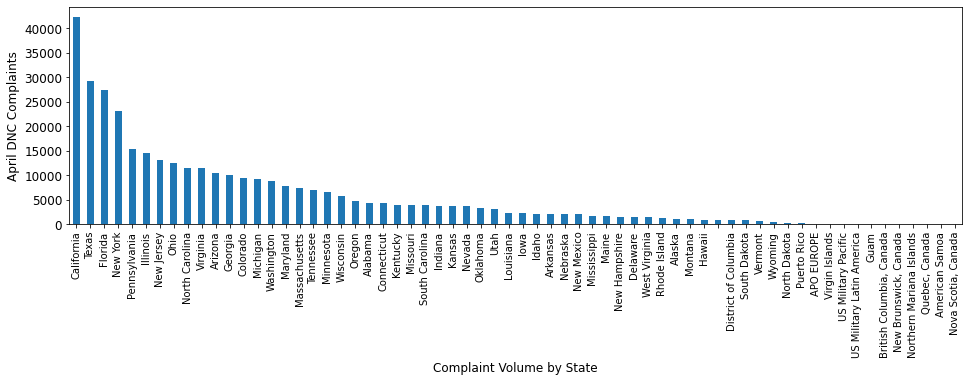

In [25]:
#Q21: Create a bar chart for complaints by state.

state_counts = dnc_df["Consumer_State"].value_counts()
plt.figure(figsize=(16, 4))
state_bars = state_counts.plot.bar()
state_bars.set_ylabel("April DNC Complaints")
state_bars.set_xlabel("Complaint Volume by State")
state_bars.tick_params(axis='x', rotation=90, labelsize=10)

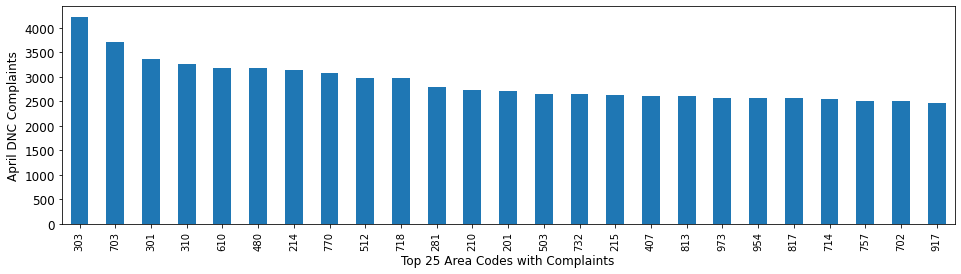

In [26]:
#Q22: Create a bar chart for the top 25 area codes with complaints.

area_code_counts = dnc_df["Consumer_Area_Code"].value_counts().nlargest(25)
plt.figure(figsize=(16, 4))
area_code_bars = area_code_counts.plot.bar()
area_code_bars.set_ylabel("April DNC Complaints")
area_code_bars.set_xlabel("Top 25 Area Codes with Complaints")
area_code_bars.tick_params(axis='x', rotation=90, labelsize=10)

Text(0.5, 0, 'Percent of Recorded Messages or Robocalls')

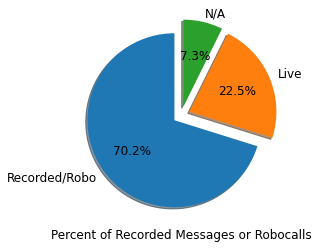

In [27]:
#Q23: Create a pie chart for the percentage of Recorded Messages or Robocalls.

robo_calls = dnc_df['Recorded_Message_Or_Robocall'].value_counts()
labels = 'Recorded/Robo', 'Live', 'N/A'
explode = (0.1, 0.1, 0.1)
ax = robo_calls.plot.pie(y='Recorded_Message_Or_Robocall', explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.set_ylabel(None)
ax.set_xlabel("Percent of Recorded Messages or Robocalls")

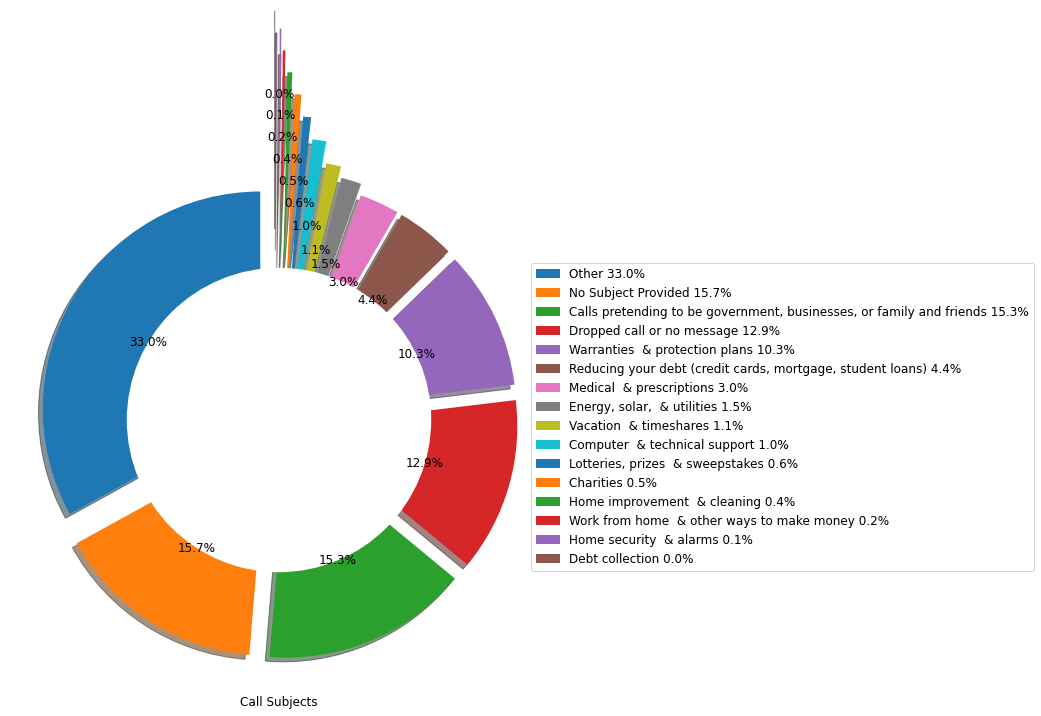

In [28]:
subject_type = dnc_df['Subject'].value_counts()
index = subject_type.index
rows = len(index)

subject_types = dict(dnc_df['Subject'].value_counts())
subjects = []
totals = []
number_subjects = 16
for key in sorted(subject_types, key=subject_types.get, reverse=True):
    subjects.append(key)
    totals.append(subject_types.get(key))
subject_sample = subjects[0:number_subjects]
totals_sample = totals[0:number_subjects]

#labels = 'Recorded/Robo', 'Live', 'N/A'
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)
wedgeprops = {'linewidth': 1}
ax = subject_type.plot.pie(explode=explode, labels=None, autopct='%1.1f%%', shadow=True, startangle=90, wedgeprops=wedgeprops, rotatelabels=True)
ax.set_ylabel(None)
ax.set_xlabel("Call Subjects")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
fig.set_size_inches(10,10)
#plt.legend(ax[0], labels, loc="upper corner", bbox_to_anchor = (1,1))
plt.legend(labels=[f'{x} {np.round(y/sum(totals_sample)*100,1)}%' for x,y in subject_types.items()], loc="upper right", bbox_to_anchor=(1.9, .8))

In [70]:
#df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

state_codes = {
    'District of Columbia' : 'DC','Mississippi': 'MS', 'Oklahoma': 'OK', 
    'Delaware': 'DE', 'Minnesota': 'MN', 'Illinois': 'IL', 'Arkansas': 'AR', 
    'New Mexico': 'NM', 'Indiana': 'IN', 'Maryland': 'MD', 'Louisiana': 'LA', 
    'Idaho': 'ID', 'Wyoming': 'WY', 'Tennessee': 'TN', 'Arizona': 'AZ', 
    'Iowa': 'IA', 'Michigan': 'MI', 'Kansas': 'KS', 'Utah': 'UT', 
    'Virginia': 'VA', 'Oregon': 'OR', 'Connecticut': 'CT', 'Montana': 'MT', 
    'California': 'CA', 'Massachusetts': 'MA', 'West Virginia': 'WV', 
    'South Carolina': 'SC', 'New Hampshire': 'NH', 'Wisconsin': 'WI',
    'Vermont': 'VT', 'Georgia': 'GA', 'North Dakota': 'ND', 
    'Pennsylvania': 'PA', 'Florida': 'FL', 'Alaska': 'AK', 'Kentucky': 'KY', 
    'Hawaii': 'HI', 'Nebraska': 'NE', 'Missouri': 'MO', 'Ohio': 'OH', 
    'Alabama': 'AL', 'Rhode Island': 'RI', 'South Dakota': 'SD', 
    'Colorado': 'CO', 'New Jersey': 'NJ', 'Washington': 'WA', 
    'North Carolina': 'NC', 'New York': 'NY', 'Texas': 'TX', 
    'Nevada': 'NV', 'Maine': 'ME', 'Puerto Rico': 'PR', 'Virgin Islands': 'VI',
    'US Military Pacific': 'USMP', 'APO EUROPE': 'APOE', 'Guam': 'G',
    'Northern Mariana Islands': 'NMI', 'British Columbia, Canada': 'BC',
    'Nova Scotia, Canada': 'NS', 'US Military Latin America': 'UMLA',
    'American Samoa': 'AM', 'New Brunswick, Canada': 'NB', 'Quebec, Canada': 'Q',
    '': 'N/A'}

dnc_df['State_Code'] = dnc_df['Consumer_State'].apply(lambda x : state_codes[x])
#complaints_per_state = dnc_df['State_Code'].value_counts()

fig = go.Figure(data=go.Choropleth(
    locations=dnc_df['State_Code'].value_counts().index, # Spatial coordinates
    z = dnc_df['State_Code'].value_counts(), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Complaints",
))

fig.update_layout(
    title_text = 'DNC Complaints by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [31]:
#Q24: What date recorded the highest amount of complaints?

violation_day_counts = dnc_df["Violation_Date"].value_counts()
violation_day_counts

2021-04-06    24402
2021-03-31    19239
2021-04-09    18096
2021-04-14    16366
2021-04-01    16142
              ...  
2013-02-04        1
2011-04-24        1
2019-12-05        1
2020-03-18        1
2021-11-10        1
Name: Violation_Date, Length: 488, dtype: int64

In [32]:
#Q25: Query the complaints from the date found above and determine the frequency of calls over time.

complaints_for_date = dnc_df[dnc_df.Violation_Date=='2021-04-06'][['Violation_Timestamp']]
complaints_for_date.value_counts('Violation_Timestamp')

Violation_Timestamp
2021-04-06 00:00:00    716
2021-04-06 12:00:00    637
2021-04-06 10:00:00    134
2021-04-06 13:00:00    127
2021-04-06 15:00:00    118
                      ... 
2021-04-06 20:23:00      1
2021-04-06 03:12:00      1
2021-04-06 20:46:00      1
2021-04-06 20:49:00      1
2021-04-06 03:52:00      1
Length: 1134, dtype: int64

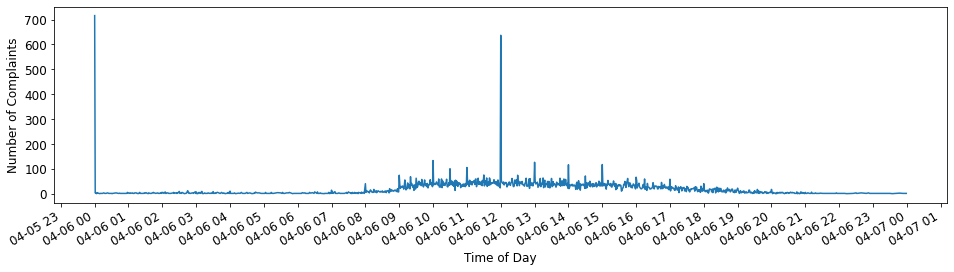

In [33]:
#Q26: Plot the data from above in a line graph.

plt.figure(figsize=(16, 4))
complaints_line_plot = complaints_for_date.Violation_Timestamp.value_counts().sort_values().plot.line()
complaints_line_plot.set_ylabel("Number of Complaints")
complaints_line_plot.set_xlabel("Time of Day")
complaints_line_plot.xaxis.set_major_locator(mdates.HourLocator(interval=1))

In [34]:
#Q27: Create a database table with the DNC data.

conn = sqlite3.connect('dnc_db.db')
c = conn.cursor()

c.execute('''CREATE TABLE IF NOT EXISTS COMPLAINTS
             ([Row] INTEGER PRIMARY KEY, [Company_Phone_Number] text, [Created_Timestamp] text, [Created_Date] text, [Created_Day] text, [Created_Time] text, [Violation_Timestamp] text, [Violation_Date] text, [Violation_Day] text, [Violation_Time] text, [Consumer_City] text, [Consumer_State] text, [Consumer_Area_Code] integer, [Subject] text, [Recorded_Message_Or_Robocall] text)''')
                 
conn.commit()

dnc_df.to_sql('COMPLAINTS', conn, if_exists='replace', index = False)

c.execute('''SELECT * FROM COMPLAINTS''')

In [35]:
#Q28: Query all complaints from the 608 area code.

query = "select * from COMPLAINTS where Consumer_Area_Code=608"
pd.read_sql(query, conn)

,Company_Phone_Number,Created_Timestamp,Created_Date,Created_Day,Created_Time,Violation_Timestamp,Violation_Date,Violation_Day,Violation_Time,Consumer_City,Consumer_State,Consumer_Area_Code,Subject,Recorded_Message_Or_Robocall,Violation_Hour,State_Code
0,6236940887,2021-03-31 00:01:00,2021-03-31 00:00:00,Wednesday,00:01:00.000000,2021-03-30 17:06:00,2021-03-30 00:00:00,Tuesday,17:06:00.000000,Mesa,Arizona,608,Other,,17.0,AZ
1,5086899813,2021-03-31 08:41:00,2021-03-31 00:00:00,Wednesday,08:41:00.000000,2021-03-30 16:30:00,2021-03-30 00:00:00,Tuesday,16:30:00.000000,Madison,Wisconsin,608,Other,Y,16.0,WI
2,6084271212,2021-03-31 09:14:00,2021-03-31 00:00:00,Wednesday,09:14:00.000000,2021-03-30 14:15:00,2021-03-30 00:00:00,Tuesday,14:15:00.000000,,Wisconsin,608,No Subject Provided,Y,14.0,WI
3,4072357444,2021-03-31 10:05:00,2021-03-31 00:00:00,Wednesday,10:05:00.000000,2021-03-29 15:59:00,2021-03-29 00:00:00,Monday,15:59:00.000000,,Wisconsin,608,No Subject Provided,N,15.0,WI
4,6083667500,2021-03-31 10:23:00,2021-03-31 00:00:00,Wednesday,10:23:00.000000,2021-03-29 14:09:00,2021-03-29 00:00:00,Monday,14:09:00.000000,Fall River,Wisconsin,608,"Calls pretending to be government, businesses,...",Y,14.0,WI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,8445691326,2021-04-29 18:43:54,2021-04-29 00:00:00,Thursday,18:43:54.000000,2021-04-29 23:35:00,2021-04-29 00:00:00,Thursday,23:35:00.000000,Madison,Wisconsin,608,Other,Y,23.0,WI
1214,6084547703,2021-04-29 18:55:08,2021-04-29 00:00:00,Thursday,18:55:08.000000,2021-04-29 16:59:00,2021-04-29 00:00:00,Thursday,16:59:00.000000,MONTELLO,Wisconsin,608,"Calls pretending to be government, businesses,...",Y,16.0,WI
1215,8883455510,2021-04-29 19:30:31,2021-04-29 00:00:00,Thursday,19:30:31.000000,2021-04-29 09:11:00,2021-04-29 00:00:00,Thursday,09:11:00.000000,Madison,Wisconsin,608,Other,Y,9.0,WI
1216,8438731252,2021-04-29 21:41:51,2021-04-29 00:00:00,Thursday,21:41:51.000000,2021-04-29 11:00:00,2021-04-29 00:00:00,Thursday,11:00:00.000000,New Lisbon,Wisconsin,608,Other,N,11.0,WI


In [36]:
#Q29: How many violations occurred on a Friday?

query = "select COUNT(*) from COMPLAINTS where Violation_Day='Friday'"
pd.read_sql(query, conn)

,COUNT(*)
0,65394


In [37]:
#Q30: How many violations occurred in each city, on the weekend, in the midwest?

query = "select Consumer_State, Consumer_City, COUNT(*) from COMPLAINTS where Consumer_State='North Dakota' or Consumer_State='South Dakota' or Consumer_State='Nebraska' or Consumer_State='Kansas' or Consumer_State='Minnesota' or Consumer_State='Iowa' or Consumer_State='Missouri' or Consumer_State='Wisconsin' or Consumer_State='Illinois' or Consumer_State='Michigan' or Consumer_State='Indiana' or Consumer_State='Ohio' and Violation_Day='Saturday' or Violation_Day='Sunday' group by Consumer_City order by Consumer_State"
pd.read_sql(query, conn)

,Consumer_State,Consumer_City,COUNT(*)
0,,UNKNOWN,1
1,,cienega de flores,1
2,Alabama,Adger,1
3,Alabama,Al,1
4,Alabama,Citronelle,1
...,...,...,...
4938,Wisconsin,woodruff,1
4939,Wyoming,Casper,1
4940,Wyoming,Dubois,1
4941,Wyoming,Laramie,1


In [38]:
# Drop Table if the exception isn't working or the table is locked.

#query = "DROP TABLE COMPLAINTS"

In [39]:
# Install jupyter_kernel_gateway, requests

import requests
from urllib3.exceptions import InsecureRequestWarning

def sendPayload():
    url="https://api.ftc.gov/v0/hsr-early-termination-notices?api_key=DprmzgqOcdByoRg3dPSpw4BRPxrPLoOcidTh5bCI"
    response = requests.request("GET", url)
    return response.text
if __name__ == "__main__":
    print(sendPayload())

SSLError: HTTPSConnectionPool(host='api.ftc.gov', port=443): Max retries exceeded with url: /v0/hsr-early-termination-notices?api_key=DprmzgqOcdByoRg3dPSpw4BRPxrPLoOcidTh5bCI (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)')))